In [1]:
using DataFrames, CSV, DelimitedFiles, Plots, FFTW
include("/home/kirk/Documents/research/CHANDRATest/DJM.jl")

Main.DJM

In [2]:
pows12=CSV.read("cxc.fftinfo.all12")

,obsid,srcnum,startdate,exptime,ra,dec,freq,power
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1026,26,51833.8,6458.48,19.9382,-73.4501,0.00123975,13.2664
2,1028,105,51856.5,6324.74,19.038,-73.414,0.000316292,13.824
3,1028,113,51856.5,6324.74,18.9547,-73.4035,0.00110873,31.303
4,1028,113,51856.5,6324.74,18.9547,-73.4035,0.00126712,12.1519
5,1028,38,51856.5,6324.74,19.8812,-73.5169,0.00110816,21.5887
6,1028,88,51856.5,6324.74,19.1853,-73.4323,0.000316454,12.6433
7,1029,13,52024.6,6120.26,19.6143,-73.4658,0.00115807,56.0898
8,1030,14,52025.6,6152.72,19.6181,-73.4675,0.00114639,74.6027
9,1030,14,52025.6,6152.72,19.6181,-73.4675,0.00212901,18.2923


In [2]:
function pdot(f) #change in period due to accretion, serious estimating involved
    Pdot2 = -2  #seconds/year
    Pdot1 = -5
    P1 = 0
    P2 = 3
    plog=log10(1/f)

    dpdot = (Pdot2 - Pdot1)/(P2-P1)
    logpdot = Pdot1 + (plog-P1)*dpdot
    return(10^logpdot)
end

pdot (generic function with 1 method)

In [5]:
#TEST 2 WITH NEW CODE FROM DARYL
allocationsGCDIST=0
ifAllocations=0

function pmatch(pows12)
    global allocationsGCDIST #Kirk added
    global ifAllocations #Kirk added
    #deltaT=20.  #years
    dflen = size(pows12)[1]
    #println(dflen)
    fi=zeros(Float64,dflen)
    fj=zeros(Float64,dflen)
    poi=zeros(Float64,dflen)
    poj=zeros(Float64,dflen)
    obsi=zeros(Int,dflen)
    obsj=zeros(Int,dflen)
    srci=zeros(Int,dflen)
    srcj=zeros(Int,dflen)
    rai=zeros(Float64,dflen)
    raj=zeros(Float64,dflen)
    dci=zeros(Float64,dflen)
    dcj=zeros(Float64,dflen)
    nsame = 0
    #nsmatch = 0

    for i = 1:dflen
        for j = i+1:dflen
            function toTime()
                if pows12.obsid[i] != pows12.obsid[j]
                    rdist,gcAllocation = DJM.gcdist(pows12.ra[j],pows12.dec[j],pows12.ra[i],pows12.dec[i]) #Kirk changed
                    allocationsGCDIST+=gcAllocation #Kirk added
                    fave = (pows12.freq[i] + pows12.freq[j])/2.0
                    Pdot = pdot(fave)
                    deltaT = abs(pows12.startdate[i] - pows12.startdate[j])/365.25
                    deltaf = fave*fave*Pdot*deltaT  #likely limit of frequency change

                    df1=1/pows12.exptime[i]
                    df2=1/pows12.exptime[j]
                    df = maximum([df1,df2])
                    #frange = df1+df2
                    numdf = ceil(deltaf/df) #how many of the largest frequency spaces could it have drifted?

                    fdiff = abs(pows12.freq[i] - pows12.freq[j])
                    frange = df*numdf

                    if ((rdist*60.0 < 0.01666) && (fdiff < frange))
                    #if ((rdist*60.0 < 0.01666) && (fdiff < frange))
                        print(nsame,"\r")
                        #println(pows12.obsid[i]," ",pows12.srcnum[i]," ",pows12.freq[i]," ",pows12.power[i]," ",pows12.obsid[j]," ",pows12.srcnum[j]," ",pows12.freq[j]," ",pows12.power[j])
                        nsame += 1
                        fi[nsame]=pows12.freq[i]
                        fj[nsame]=pows12.freq[j]
                        poi[nsame]=pows12.power[i]
                        poj[nsame]=pows12.power[j]
                        obsi[nsame]=pows12.obsid[i]
                        obsj[nsame]=pows12.obsid[j]
                        srci[nsame]=pows12.srcnum[i]
                        srcj[nsame]=pows12.srcnum[j]
                        rai[nsame]=pows12.ra[i]
                        raj[nsame]=pows12.ra[j]
                        dci[nsame]=pows12.dec[i]
                        dcj[nsame]=pows12.dec[j]
                    end

                end
            end
            ifAllocations+=@allocated toTime()
        end
    end


    same=[obsi[1:nsame] srci[1:nsame] rai[1:nsame] dci[1:nsame] fi[1:nsame] poi[1:nsame] obsj[1:nsame] srcj[1:nsame] raj[1:nsame] dcj[1:nsame] fj[1:nsame] poj[1:nsame]]
    return same
end

using Formatting

x=@timed pmatch(pows12)
nsame=size(x[1])
println(nsame[1]," matches")
gb=x[3]/10^9
t=x[2]
println(format(t,precision=3)," seconds\n",format(gb,precision=3)," GB used")
println(format(allocationsGCDIST/10^9,precision=3)," GB used JUST in gcdist")
println(format(ifAllocations/10^9,precision=3)," GB used JUST in if statement allocating")
println(format(ifAllocations/10^9+allocationsGCDIST/10^9-gb,precision=3)," GB difference ")
#return(notsame)

128 matches
10.447 seconds
2.637 GB used
0.510 GB used JUST in gcdist
2.124 GB used JUST in if statement allocating
-0.003 GB difference 


In [17]:
function test(pows12)
    dflen = size(pows12)[1]
    #println(dflen)
    fi=zeros(Float64,dflen)
    fj=zeros(Float64,dflen)
    poi=zeros(Float64,dflen)
    poj=zeros(Float64,dflen)
    obsi=zeros(Int,dflen)
    obsj=zeros(Int,dflen)
    srci=zeros(Int,dflen)
    srcj=zeros(Int,dflen)
    rai=zeros(Float64,dflen)
    raj=zeros(Float64,dflen)
    dci=zeros(Float64,dflen)
    dcj=zeros(Float64,dflen)
end

alloc=@allocated test(pows12)
println(alloc/10^9)

0.000586511


In [7]:
function binnedPowers(powerList)
    for i in 1:length(powerList)
        powerList[i]=Int(floor(powerList[i]))
    end
    return powerList
end

powerList=pows12.power[:]

1857-element Array{Float64,1}:
 13.26639442198474 
 13.824045072134274
 31.30296801294995 
 12.151857527493563
 21.588660290323755
 12.643323725876892
 56.08978033423794 
 74.60268271242722 
 18.292340809612156
 17.889771451447622
 17.836005321642993
 12.007554962599025
 17.852373571024664
  ⋮                
 13.127043886737253
 14.729428981890102
 13.645409843148206
 19.711629885678484
 12.610913641754763
 12.921045133163451
 12.518823111641408
 16.474454025116216
 14.63269595358057 
 12.884031518031474
 13.630256152523229
 12.151184715929253

[15.0, 14.0, 14.0, 13.0, 13.0, 12.0, 12.0, 1783.0, 1770.0, 1756.0, 1896.0, 1742.0, 1726.0, 1710.0, 1694.0, 1677.0, 1659.0, 1641.0, 1622.0, 1603.0, 1583.0]
83.96715131933226


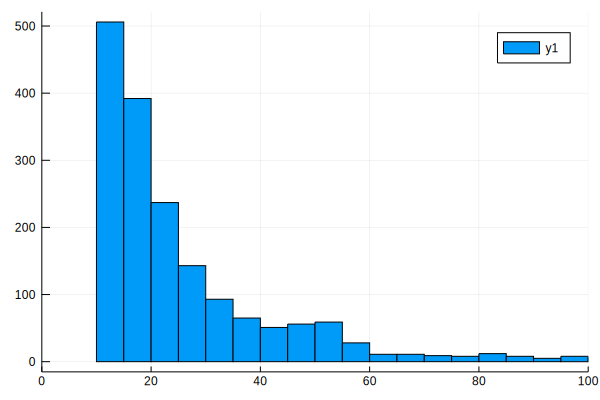

In [48]:
using Statistics,Plots
powerListBinned=binnedPowers(powerList)
max,index=findmax(powerListBinned)

println(powerListBinned[index-10:index+10])
println(mean(powerListBinned))

histogram(powerListBinned,xlims=(0,100))

# From here on is what we were focusing on today

In [23]:
println((pows12.freq[1]+pows12.freq[2])/2," favg calc")

0.0007780213591349969 favg calc


In [20]:
using Formatting
#Note: running this function for pows8 took ~2.5min on my laptop
function createPowMatrix(powList)
    n=ceil(maximum(powList.power[:]))
    df=0.0001
    nk=ceil(maximum(powList.freq[:])/df)
    powMatrix=zeros(101,101,Int(nk)+1) #any power greater than 100 will go in 101,nk for freq z direction, +1 because 1 is for normal matrix
    justPow=powList.power[:]
    errorCount=0
    counter=0
    for i in 1:length(justPow)
        print(format(i/length(justPow)*100,precision=2),"% complete\r") #output % tracker
        if ceil(powList.power[i])>100
            currentRow=101 #power is too big
        else
            currentRow=ceil(powList.power[i]) #row index for use later
        end
        
        for j in (i+1):length(justPow) #i+1 accounts for indistinguishability
            counter+=1
            if ceil(powList.power[j])>100
                currentCol=101 #other power too big
            else
               currentCol=ceil(powList.power[j]) #column index for use later
            end
            try #need to use try statement because gcdist breaks sometimes?
                rdist = DJM.gcdist(powList.ra[j],powList.dec[j],powList.ra[i],powList.dec[i])
                if (rdist*60.0 > 0.01666) #not in the same place
                    powMatrix[Int(currentRow),Int(currentCol),1]+=1 #found a pair, doesn't account for overcounting (indistinguishability)
                    #stuff below for freq z part of matrix
                    fAvg=(powList.freq[i]+powList.freq[j])/2
                    fAvgDot=1/pdot(fAvg)
                    dt=abs(powList.exptime[i]-powList.exptime[j]) #is exptime the timestamp?
                    fRangeMax=fAvgDot*dt
                    fRangeMin=fAvgDot*(-dt)
                        if fAvg>=fRangeMin && fAvg<=fRangeMax
                            kInd=ceil(fAvg/df)                                
                            #println(kInd," successfully appended to k index") note: it does work!
                            powMatrix[Int(currentRow),Int(currentCol),Int(kInd+1)]+=1 #kInd+1 because 1 is base matrix
                        end
                end
            catch
                errorCount+=1 #this error is because it tries to take acos of #>1 (I think) in gcdist
                              #maybe because of rounding errors?
            end
        end
    end
    println(errorCount," total errors accumulated")
    println(errorCount/counter*100,"% error")
    return powMatrix
end

test=@timed createPowMatrix(pows12)
testMatrix=test[1]
time=test[2]

3094 total errors accumulated
0.17953967281302805% error


5.69850047

In [21]:
println("time elapsed for 1857 entries, ",time/60," min")
println("time required to process 8 list at this rate = ",time/(60*1857)*11255," min")
println("time required to process 0 list at this rate = ",time/(3600*1857*24)*42380567," days")

time elapsed for 1857 entries, 0.09497500783333333 min
time required to process 8 list at this rate = 0.575629355500359 min
time required to process 0 list at this rate = 1.505225977833912 days


In [22]:
pows8=CSV.read("cxc.fftinfo.all8")

,obsid,srcnum,startdate,exptime,ra,dec,freq,power
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1026,26,51833.8,6458.48,19.9382,-73.4501,0.00123975,13.2664
2,1026,8,51833.8,6458.48,19.5522,-73.6193,0.154427,9.16655
3,1027,107,51855.0,6133.27,18.8667,-73.3961,0.0185454,9.14431
4,1027,107,51855.0,6133.27,18.8667,-73.3961,0.144096,8.02378
5,1027,36,51855.0,6133.27,19.782,-73.5006,0.0813522,8.00401
6,1027,40,51855.0,6133.27,19.7033,-73.4917,0.0417401,8.04439
7,1027,54,51855.0,6133.27,19.5056,-73.4696,0.14484,8.14304
8,1027,58,51855.0,6133.27,19.4489,-73.4632,0.0598763,8.05626
9,1027,91,51855.0,6133.27,19.0827,-73.4213,0.0622972,8.75528


In [23]:
test8=@timed createPowMatrix(pows8)
println("took ",format(test8[2]/60,precision=2)," min")
tPrev=1.09
println("roughly ",format(test8[2]/(tPrev*60),precision=2)," x 2D time")

13475 total errors accumulated
0.021276802356348625% error
took 2.90 min
roughly 2.66 x 2D time


In [10]:
println(test8[2]/60)

4.144378206133333


In [106]:
using Plots, Formatting
function darylCuriosity(powList,deltaf,bounds)
    justPow=powList.power[:]
    freqList=[]
    for i in 1:length(justPow)
        print(format(i/length(justPow)*100,precision=2),"% complete\r")
        power=powList.power[i]
        freq=powList.freq[i]
        if freq<=1 && power>=100
            for j in 1:Int(ceil((maximum(bounds)-minimum(bounds))/deltaf))
                if freq<j*deltaf && freq>(j-1)*deltaf
                    push!(freqList,j*deltaf)
                end
            end
        end
    end
    return freqList
end
           

darylCuriosity (generic function with 1 method)

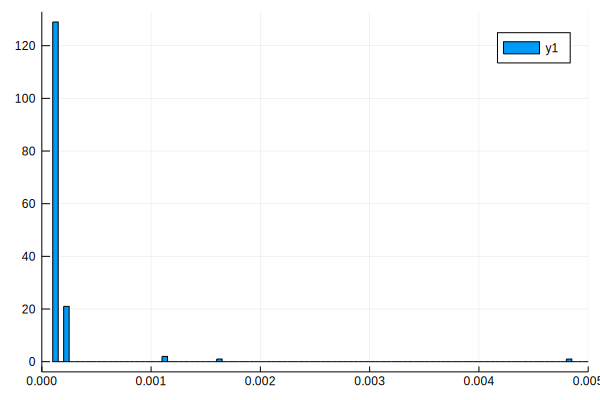

In [109]:
bounds=(0,0.16)
deltaf=0.0001
freqList=darylCuriosity(pows8,deltaf,bounds)
histogram(freqList,bins=Int(ceil((maximum(bounds)-minimum(bounds))/deltaf)),xlims=(0,0.005))

In [9]:
println(maximum(pows8.freq[:]))

0.1545010390550711


In [117]:
pows8Binned=binnedPowers(pows8.power[:])
counter100=0
counter8=0
for i in 1:length(pows8Binned)
    if pows8Binned[i]>100
        counter100+=1
    elseif pows8Binned[i]==8
        counter8+=1
    end
end

In [121]:
println(counter100)
println(counter8)
println(counter8*counter100)

print(test8[9,9])

155
5910
916050
3.4903506e7

,obsid,srcnum,startdate,exptime,ra,dec,freq,power
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,14261,1,55943.0,10027.6,16.0085,-72.0314,0.000199446,0.199153
2,14261,1,55943.0,10027.6,16.0085,-72.0314,0.000299169,0.165177
3,14261,1,55943.0,10027.6,16.0085,-72.0314,0.000398892,0.181806
4,14261,1,55943.0,10027.6,16.0085,-72.0314,0.000498615,0.0689986
5,14261,1,55943.0,10027.6,16.0085,-72.0314,0.000598338,0.00579191
6,14261,1,55943.0,10027.6,16.0085,-72.0314,0.000698061,0.10447
7,14261,1,55943.0,10027.6,16.0085,-72.0314,0.000797784,0.0385035
8,14261,1,55943.0,10027.6,16.0085,-72.0314,0.000897507,0.125732
9,14261,1,55943.0,10027.6,16.0085,-72.0314,0.00099723,0.178718


In [27]:
n0=42380567 #number of entries in 0 list
rate=11255/test8[2]
t0=(n0/11255)^(3/2)*test8[2]
t0Days=t0/24/3600
println("at current rate processing zero list would take ",format(t0Days,precision=2)," days (on this machine)")

at current rate processing zero list would take 464.60 days (on this machine)


In [29]:
println(t0Days/4)

116.14970809768165
